In [1]:
# 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.regularizers import l2
from sklearn.inspection import permutation_importance


In [2]:
# 2: Load and Preprocess Data

def load_and_preprocess_data(file_path):
    df = pd.read_sas(file_path, encoding='LATIN2')
    df = df[('197501' <= df['period']) & (df['period'] <= '198712') & 
            (df['product'] == 'css') & (df['decision'] == 'A')]
    
    # Identify features and target
    features = [col for col in df.columns if col.startswith(('app', 'act'))]
    X = df[features]
    y = df['default12']
    
    # Store original feature names
    original_feature_names = features.copy()
    
    # Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns
    
    # Create preprocessing steps
    numeric_transformer = SimpleImputer(strategy='mean')
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Fit and transform the data
    X_processed = preprocessor.fit_transform(X)
    
    # Get feature names after preprocessing
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features)
    feature_names = list(numeric_features) + list(cat_feature_names)
    
    # Convert to DataFrame
    X_processed = pd.DataFrame(X_processed, columns=feature_names)
    
    # Remove rows with NaN in the target variable
    mask = ~y.isna()
    X_processed = X_processed[mask]
    y = y[mask]
    
    return X_processed, y, original_feature_names

# Load the data
file_path = 'C:/Users/khtur/Desktop/Eas/Models/abt_app.sas7bdat'  # Your file path
X, y, original_feature_names = load_and_preprocess_data(file_path)

print("Data shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True))

# Display info about the processed dataset
print("\nProcessed data info:")
X.info()

# Display the first few rows of the processed data
print("\nFirst few rows of processed data:")
print(X.head())

# Print original feature names
print("\nOriginal feature names:")
print(original_feature_names)

Data shape: (9861, 63)
Target distribution:
 default12
0.0    0.509583
1.0    0.490417
Name: proportion, dtype: float64

Processed data info:
<class 'pandas.core.frame.DataFrame'>
Index: 9861 entries, 0 to 11436
Data columns (total 63 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   act_age                            9861 non-null   float64
 1   act_cc                             9861 non-null   float64
 2   act_loaninc                        9861 non-null   float64
 3   app_income                         9861 non-null   float64
 4   app_loan_amount                    9861 non-null   float64
 5   app_n_installments                 9861 non-null   float64
 6   app_number_of_children             9861 non-null   float64
 7   app_spendings                      9861 non-null   float64
 8   app_installment                    9861 non-null   float64
 9   act_call_cc                        9861 non-nu

In [3]:
# Cell 3: Variable Selection
def select_variables(X, y, threshold=0.05):
    # Function to calculate correlation and handle errors
    def safe_corr(x, y):
        if x.dtype not in ['int64', 'float64']:
            return 0
        if len(x.unique()) == 1:  # Constant column
            return 0
        corr = x.corr(y)
        return corr if not np.isnan(corr) else 0

    correlations = X.apply(lambda x: safe_corr(x, y))
    
    # Select features based on absolute correlation
    selected_features = correlations[abs(correlations) > threshold].index.tolist()
    
    print(f"Total features: {X.shape[1]}")
    print(f"Features selected: {len(selected_features)}")
    print("Top 10 features by absolute correlation:")
    print(correlations.abs().sort_values(ascending=False).head(10))
    
    return X[selected_features]

# Select variables
X_selected = select_variables(X, y)

print(f"\nShape of X after variable selection: {X_selected.shape}")

Total features: 63
Features selected: 37
Top 10 features by absolute correlation:
act6_n_arrears           0.435683
act3_n_arrears           0.435396
act9_n_arrears           0.417456
act12_n_arrears          0.399079
act_ccss_maxdue          0.374753
act_ccss_dueutl          0.349444
act_ccss_n_statC         0.298171
act_ccss_n_loans_hist    0.251190
act6_n_arrears_days      0.212507
act3_n_arrears_days      0.209767
dtype: float64

Shape of X after variable selection: (9861, 37)


In [4]:
# Cell 4: Split the Data
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Cell 5: Build and Train Model
def build_and_train_model(X_train, y_train, X_val, y_val):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),  # Use Input layer to specify input shape
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=150, batch_size=32, callbacks=[early_stopping], verbose=1)
    
    return model, history

# Build and train the model
model, history = build_and_train_model(X_train_scaled, y_train, X_val_scaled, y_val)

# Print model summary
model.summary()

Epoch 1/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6064 - loss: 1.5917 - val_accuracy: 0.7556 - val_loss: 0.9945
Epoch 2/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7559 - loss: 0.9107 - val_accuracy: 0.7647 - val_loss: 0.6996
Epoch 3/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7613 - loss: 0.6814 - val_accuracy: 0.7819 - val_loss: 0.5873
Epoch 4/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7804 - loss: 0.5816 - val_accuracy: 0.7830 - val_loss: 0.5445
Epoch 5/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7764 - loss: 0.5553 - val_accuracy: 0.7825 - val_loss: 0.5285
Epoch 6/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7799 - loss: 0.5417 - val_accuracy: 0.7850 - val_loss: 0.5143
Epoch 7/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7827 - loss: 0.5182 - val_accuracy: 0.7860 - val_loss: 0.5128
Epoch 8/150
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7796 - loss: 0.5188 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,173 (59.27 KB)

 Trainable params: 5,057 (19.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,116 (39.52 KB)

In [6]:
# Cell 6: Evaluate Model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred)
    gini = 2 * auc_score - 1
    print(f'Test AUC: {auc_score:.4f}')
    print(f'Test Gini: {gini:.4f}')
    return y_pred

# Evaluate the model
y_pred = evaluate_model(model, X_test_scaled, y_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test AUC: 0.8616
Test Gini: 0.7231


185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step


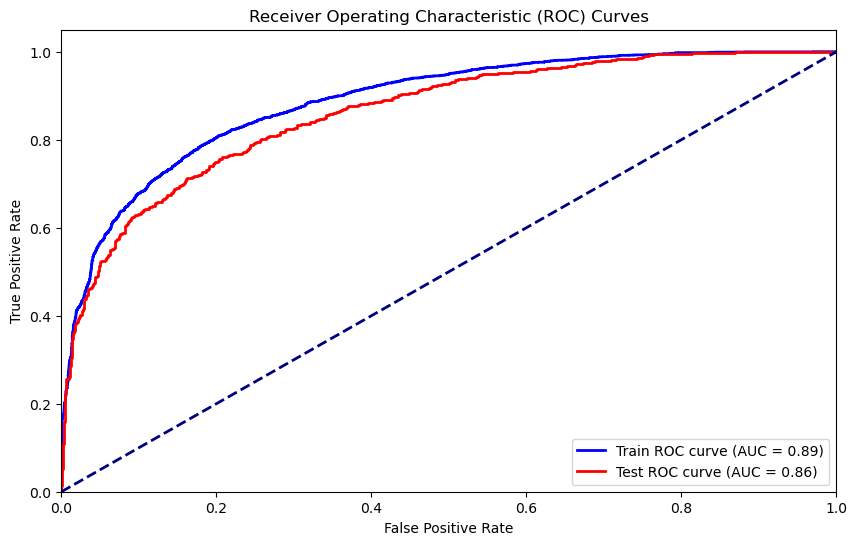

Train AUC: 0.8867
Test AUC: 0.8616
Train Gini: 0.7734
Test Gini: 0.7231


In [7]:
# Cell 7: Plot ROC Curves for Train and Test Sets
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curves(model, X_train, y_train, X_test, y_test):
    # Predict probabilities for train and test sets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate ROC curve and AUC for train set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
    auc_train = roc_auc_score(y_train, y_pred_train)
    
    # Calculate ROC curve and AUC for test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_pred_test)
    
    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # Print AUC scores
    print(f"Train AUC: {auc_train:.4f}")
    print(f"Test AUC: {auc_test:.4f}")
    
    # Calculate and print Gini coefficients
    gini_train = 2 * auc_train - 1
    gini_test = 2 * auc_test - 1
    print(f"Train Gini: {gini_train:.4f}")
    print(f"Test Gini: {gini_test:.4f}")

# Plot ROC curves for train and test sets
plot_roc_curves(model, X_train_scaled, y_train, X_test_scaled, y_test)

Feature names being used:
['act_age', 'act_cc', 'act_loaninc', 'app_number_of_children', 'act_call_cc', 'act_cins_n_loan', 'act_ccss_n_loan', 'act_cins_seniority', 'act_cins_n_loans_hist', 'act_cins_maxdue', 'act_cins_min_pninst', 'act_cins_utl', 'act_cins_dueutl', 'act_cins_cc', 'act_ccss_seniority', 'act_ccss_min_seniority', 'act_ccss_n_loans_hist', 'act_ccss_n_statC', 'act_ccss_n_loans_act', 'act_ccss_maxdue', 'act_ccss_min_pninst', 'act_ccss_min_lninst', 'act_ccss_utl', 'act_ccss_dueutl', 'act3_n_arrears', 'act3_n_arrears_days', 'act6_n_arrears', 'act6_n_arrears_days', 'act9_n_arrears', 'act9_n_arrears_days', 'act9_n_good_days', 'act12_n_arrears', 'act12_n_arrears_days', 'act12_n_good_days', 'app_char_job_code_Owner company', 'app_char_job_code_Retired', 'app_char_marital_status_Widowed']
Calculating SHAP values...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 3s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 3s 510us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 3s 506us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 3s 502us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 3s 510us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 3s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 3s 496us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 3s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 3s 510us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 3s 502us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 3s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6632/6632 ━━━━━━━━━━━━━━━━━━━━ 3s 499us/step
1/1 

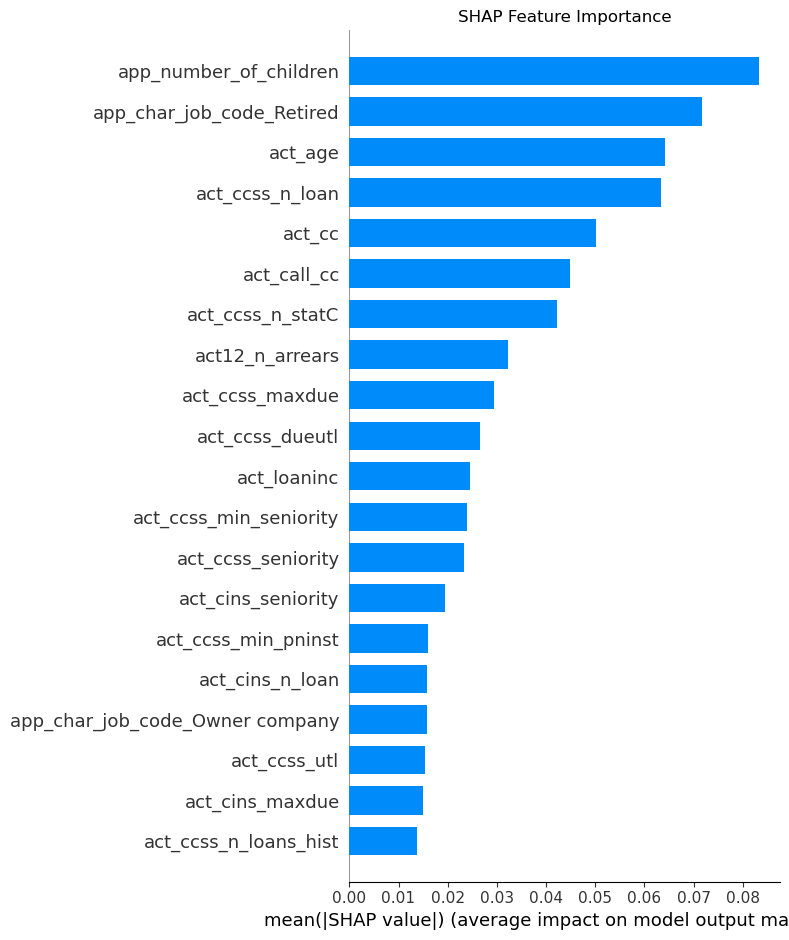


Top 10 features by SHAP importance:
                      feature  importance
3      app_number_of_children    0.083391
35  app_char_job_code_Retired    0.071625
0                     act_age    0.064172
6             act_ccss_n_loan    0.063366
1                      act_cc    0.050079
4                 act_call_cc    0.044786
17           act_ccss_n_statC    0.042243
31            act12_n_arrears    0.032275
19            act_ccss_maxdue    0.029386
23            act_ccss_dueutl    0.026628


In [8]:
# Cell 9: Feature Importance and Model Interpretation

def plot_shap_values(model, X, feature_names):
    # Create a wrapper function for the model's predict method
    f = lambda x: model.predict(x).flatten()
    
    # Create a SHAP explainer
    explainer = shap.KernelExplainer(f, shap.sample(X, 100))
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X[:100])  # Use a subset for faster computation
    
    # Plot SHAP values
    shap.summary_plot(shap_values, X[:100], plot_type="bar", feature_names=feature_names, show=False)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()

    # Print top 10 features by importance
    feature_importance = np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(feature_names, feature_importance)), columns=['feature', 'importance'])
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    print("\nTop 10 features by SHAP importance:")
    print(feature_importance.head(10))

def plot_permutation_importance(model, X, y, feature_names):
    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    
    sorted_idx = perm_importance.importances_mean.argsort()
    sorted_features = np.array(feature_names)[sorted_idx][-20:]  # Get top 20 features
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(20), perm_importance.importances_mean[sorted_idx][-20:])
    plt.yticks(range(20), sorted_features)
    plt.xlabel("Permutation Importance")
    plt.title("Top 20 Features by Permutation Importance")
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features
    feature_importance = pd.DataFrame({'feature': feature_names,
                                       'importance': perm_importance.importances_mean})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    print("\nTop 10 features by permutation importance:")
    print(feature_importance.head(10))

# Ensure we have the original feature names
if 'selected_original_features' not in globals():
    print("Warning: selected_original_features not found. Using X_selected.columns instead.")
    feature_names = X_selected.columns.tolist()
else:
    feature_names = selected_original_features

# Check if the number of features matches
if len(feature_names) != X_test_scaled.shape[1]:
    print(f"Warning: Number of feature names ({len(feature_names)}) doesn't match the number of features in X_test_scaled ({X_test_scaled.shape[1]}).")
    print("Using X_test column names instead.")
    feature_names = X_test.columns.tolist()

# Ensure X_test_scaled is a DataFrame with feature names
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

print("Feature names being used:")
print(feature_names)

# Try SHAP values first
try:
    print("Calculating SHAP values...")
    plot_shap_values(model, X_test_df, feature_names)
except Exception as e:
    print(f"Error calculating SHAP values: {e}")
    print("Falling back to permutation importance...")
    plot_permutation_importance(model, X_test_scaled, y_test, feature_names)

In [ ]:
# Cell 9: Save the Model
# Save the model
model.save('credit_scoring_nn_model.keras')

print("Model saved successfully.")